# Table Search
## Problem description
1. Table detection is handled by PyMuPDF4LLM
2. The tables may be multipage
3. The tables may be very large and/or sparse

## A separate chunking strategy for tables
The starting point for our approach is:
(Financial Report Chunking for Effective Retrieval Augmented Generation)[https://arxiv.org/abs/2402.05131]

The starting point of the approach taken (of interested is marked in **bold**)
"The steps to generate element-based chunks are:
– if the element text length is smaller than 2,048 characters, a merge with the
following element is attempted
– iteratively, element texts are merged following the step above till either the
desired length is achieved, without breaking the element
– if a title element is found, a new chunk is started
– **if a table element is found, a new chunk is started, preserving the entire table**"

We will not enforce the step **if a table element is found, a new chunk is started, preserving the entire table**.
Rather we will use structural seperators to encourage this behavior.

In addition, the files contain large table, potentially spanning multiple pages. The next section will look at a strategy based on limitations of the general chunking strategy, embedding models, rerankers and LLMs.

### Data enrichment for effective retrieval
Directly generating an embedding on tables may be undesirable.

For any table:


The task description will be placed before the table in the prompt (Table Meets LLM: Can Large Language Models Understand Structured Table Data)[https://arxiv.org/pdf/2305.13062]

```prompt
# Task
Please give a table description in plain text.

The description should include:
1. Creating a table caption
2. Describe column and row headers

# Table
{insert table}
```

### Distinction between small, medium and large tables
The upper bound for the chunk size is set by by recursive text splitter, which is set to a MAX_CHUNK_SIZE OF 1000 characters (note: technically the langchain implementation of recursive text splitter may not always respect this upper bound). 

As our strategy we opted for a different strategy depending on the size of a table. 

1. For small tables, only enriched with contextual information for better retrieval. Table embedded
2. For medium tables, contextual information + table metadata. 
3. For large tables, excluded as LLMs performance degrades significantly.

Therefore, a small table will be that will fit in the smallest chunk size. The approach for small tables is to enricht with metadata for improved retrieval.

For tables larger than MAX_CHUNK_SIZE, in a naive strategy the table will be split up. This should be prevented, because:
1. Adds additional noisy chunks
2. Later chunks do not have header metadata

On average 1 token is about 4 characters in normal text. However, this often does not hold true for tables, especially with numeric data (e.g. 1,0 or 1.0 is typically 3 tokens). Assuming the worse case the lower bound of 1 token = 1 table character, would mean a small table of 1000 characters will be 1000 tokens. The small table will also fit well within the bounds of both the embedding and LLMs with enriched data will fit well within Gemini-embedding-001, which has the smallest context window of 2048 tokens. 

| Embedding Model                | Maximum Input Token Length |
|--------------------------------|-----------------------------|
| gemini-embedding-001 (GA)      | **2048** tokens |
| text-embedding-3-large         | **8191** tokens |
| Qwen-3-Embedding-8B            | **32,000** tokens |

Tables larger than 1000 character will no longer fit in one chunk (based on our predefined chunk strategy). The rerankers have similar limitations. For the reranker, the preferred approach is to be able to put the entire table into the reranker. The MAX_TABLE_SIZE_RERANKER = 4096 tokens will serve as an upper bound for table size, which can be evaluated through the reranker.

| Rerankers | Maximum Input Token Length |
| --- | --- |
| Qwen3-Reranker-8B | 32,000 tokens |
| rerank-v3.5 | 4096 tokens |

Note: strictly speaking the context window is not a hard limitation. Alternative approaches exist.
1. Document truncation
2. Max score of documents chunks
(docs - cohere 3.5 reranker)[https://docs.cohere.com/v2/docs/reranking-best-practices]
However, the ability of LLMs to handle tables also plays a role.

In addition limitation of the reranker, the capabilities of the LLMs, shows a performance drop for gpt-4o-mini between 1K tokens (~50% column average, ~40% column substraction) --> 4K tokens (~35% column average, 41% column substraction). Based on (livebench)[https://livebench.ai/#/], recent models seem to be significantly better at handling long context. 
1. Possible to retrieve multiple large tables with a query
2. The app has chat history a large table will explode the context window
Therefore, a MAX_TABLE_SIZE_LLM = 4K characters is a good cut-off 

Lastly, the LLM may need to handle multiple tables.
The upper bound for medium-sized table is chosen based on the capabilities of LLMs, which show a significant drop off after 4k (How well do LLMs reason over tabular data, really?)[https://arxiv.org/pdf/2505.07453]. The study was performed on less recent models.

| LLM                       | Context Window Size |
|---------------------------|---------------------|
| GPT-4o Mini               | 128,000 tokens      |
| GPT-4o                    | 128,000 tokens      |
| GPT-5                     | 400,000 tokens      |
| Gemini 2.5 Pro            | 1,000,000 tokens    |
| Grok 4                    | 256,000 tokens      |



Based on the aforementioned, the following table strategy was devised.

| Category |Table Size (characters)                | Relative noise (not based on anything) |Action
|--------  |-------------------------------------  |----------------------------------------| --- |
| Small    | size < 1000 (MAX_CHUNK_SIZE)          | low                                    | Enrich for retrieval |
| Medium   | 1000 < size < 4000 (MAX_TABLE_SIZE_RERANKER && MAX_TABLE_SIZE_LLM)| medium                                 | Enrich for retrieval && replace table with description for retrieval |
| Large    | size > 4000                           | high                                   | Exclude |



final_Consolidated_GLs_CBs_ET_EN.pdf.md
final_EIOPA-BoS-14-259_Final report_ORSA.pdf.md
final_Guidelines on basis risk.pdf.md
final_Guidelines on Classification of Own Funds.pdf.md
final_Guidelines on group solvency.pdf.md
final_Guidelines on health catastrophe risk sub-module.pdf.md
final_Guidelines on look-through approach.pdf.md
final_Guidelines on operational functioning of colleges.pdf.md
final_Guidelines on Own Risk Solvency Assessment .pdf.md
final_Guidelines on reporting and public disclosure.pdf.md
final_Guidelines on ring-fenced funds.pdf.md
final_Guidelines on supervisory review process.pdf.md
final_Guidelines on the use of internal models.pdf.md
final_Guidelines on undertaking-specific parameters.pdf.md
final_JC 2024-34_Guidelines on costs and losses_DORA.pdf.md
final_Joint ESA Final Report on Art 97 Guidelines MiCAR.pdf.md
final_Joint ESA Gls MiCAR %28JC 2024 28%29_EN.pdf.md
final_Joint Guidelines on Risk Factors.pdf.md
final_Privacy Statement - ESAs Information System.pdf

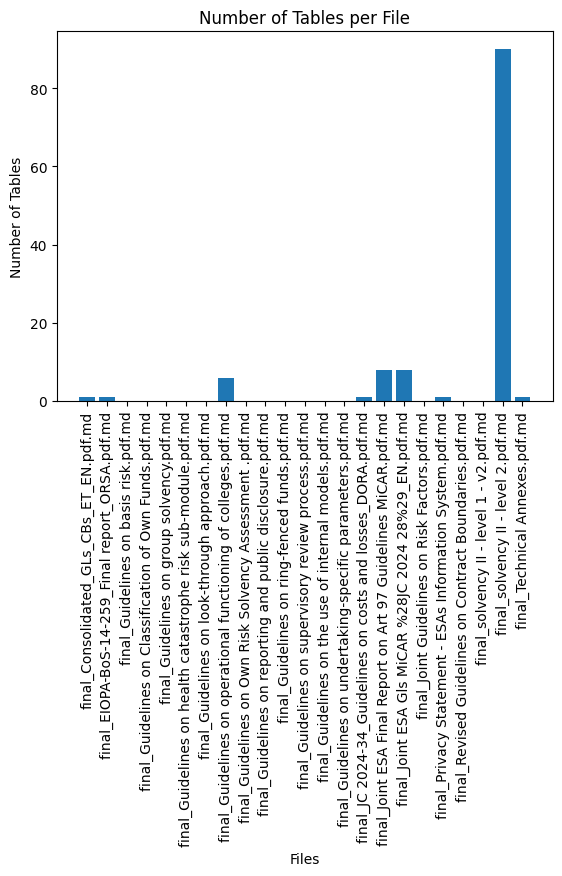

In [6]:
import os
import re
import matplotlib.pyplot as plt

# src: https://stackoverflow.com/questions/9837935/regex-for-markdown-table-syntax
# https://regex101.com/r/M5wAoq/1/

table_regex = r"^(\|[^\n]+\|\r?\n)((?:\|:?[-]+:?)+\|)(\n(?:\|[^\n]+\|\r?\n?)*)?$"

input_dir = r"..\data\preprocessed-step-2-output\solvency-II-files"
# root = r"..\data\raw\test-data\table-examples"
output_dir = r"..\data\preprocessed-step-3-debug\solvency-II-files\substep-1"
# root_new = r"..\data\raw\test-data\table-examples-out"
def add_table_marker(content):
    def replacer(match):
        table = match.group(0)

        table_formatted = f"\n<table>\n{table}"

        if not table.endswith("\n"):
            table_formatted += "\n"

        table_formatted += "</table>\n"

        return table_formatted

    content = re.sub(table_regex, replacer, content, flags=re.MULTILINE)

    return content



tables_per_file = {}
for file_name in os.listdir(input_dir):
    print(file_name)
    if os.path.isfile(os.path.join(input_dir, file_name)):
        with open(os.path.join(input_dir, file_name), "r", encoding="utf-8") as f:
            content = f.read()
        content = add_table_marker(content)

        # find table size
        matches = re.finditer("<table>(.*?\n)</table>", content, flags=re.DOTALL)
        count = 0
        tables_per_file[file_name] = {}
        tables_per_file[file_name]["table_sizes"] = []
        tables_per_file[file_name]["count"] = 0
        for match in matches:
            table = match.group(1)
            # if not file_name in tables_per_file:
            #     tables_per_file[file_name] = {"count": 0}

            # if not "table_sizes" in tables_per_file[file_name]:
            #     tables_per_file[file_name]["table_sizes"] = []      

            tables_per_file[file_name]["table_sizes"].append(len(table))

            count += 1
            
        tables_per_file[file_name].update({"count": count})

        with open(os.path.join(output_dir, file_name), "w", encoding="utf-8") as f:
            f.write(content)
    else:
        print(f"File skipping... {file_name}")
print(tables_per_file.values())
plt.bar(tables_per_file.keys(), [file_info["count"] for file_info in tables_per_file.values()])
plt.xticks(rotation=90)
plt.xlabel("Files")
plt.ylabel("Number of Tables")
plt.title("Number of Tables per File")
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(tables_per_file, with_vline=True):
    bin_edges = np.arange(0, 10001, 1000)
    for file in tables_per_file:
        print(tables_per_file[file])
        # indexes = [idx for idx, _ in enumerate(tables_per_file[file]["table_sizes"])]
        counts, bins, patches = plt.hist(tables_per_file[file]["table_sizes"], bins=bin_edges, label=file)

        # Annotate each bar
        for count, patch in zip(counts, patches):
            if count > 0:  # only annotate non-empty bins
                # Get bar center
                x = patch.get_x() + patch.get_width() / 2
                y = patch.get_height()
                plt.text(
                    x,
                    y,
                    str(int(count)),
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    rotation=0,
                )

    if with_vline:
        SMALL_TABLE_THRESHOLD = 1000
        MEDIUM_TABLE_THRESHOLD = 4000
        plt.axvline(x=SMALL_TABLE_THRESHOLD, color='red', linestyle='--', linewidth=2, label='Threshold Small Table')
        plt.axvline(x=MEDIUM_TABLE_THRESHOLD, color='blue', linestyle='--', linewidth=2, label='Threshold Medium Table')
        plt.xlabel("Table Size (characters)")
        plt.ylabel("Number of tables")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


{'table_sizes': [639], 'count': 1}
{'table_sizes': [1462], 'count': 1}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [120, 210, 356, 2253, 2678, 2573], 'count': 6}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [1356], 'count': 1}
{'table_sizes': [4016, 2403, 2493, 784, 4053, 3017, 2841, 1518], 'count': 8}
{'table_sizes': [4013, 2403, 2493, 784, 4156, 2924, 3060, 1072], 'count': 8}
{'table_sizes': [], 'count': 0}
{'table_sizes': [1132], 'count': 1}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [123, 243, 389, 264, 213, 375, 284, 246, 246, 661, 570, 242, 79, 124, 117, 164, 192, 783, 115, 305, 128, 197, 171, 119, 169, 116, 150, 178, 1213, 902, 3502, 772, 822, 481, 2007

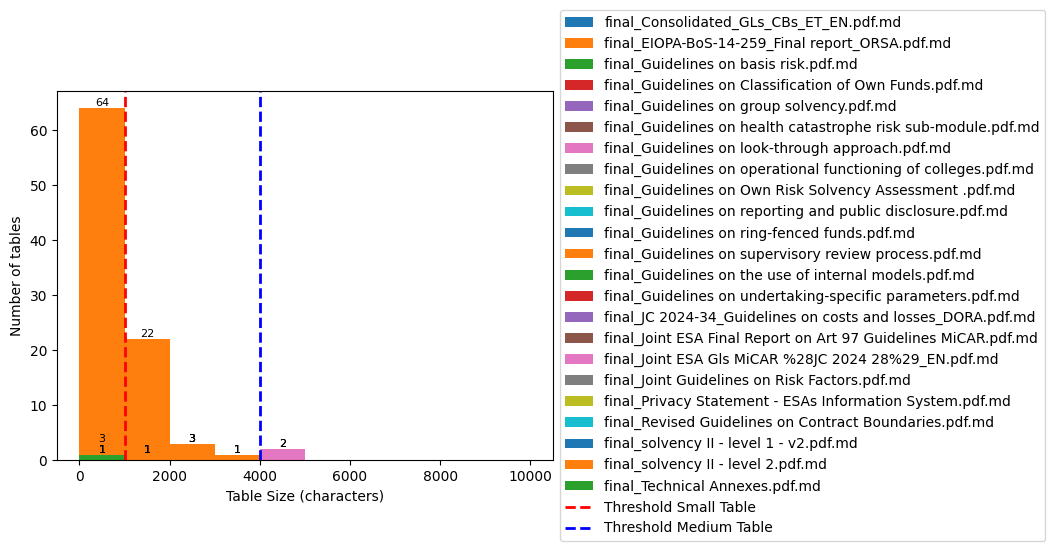

In [11]:
plot_distribution(tables_per_file)

final_Consolidated_GLs_CBs_ET_EN.pdf.md
No more matches, breaking...
{'table_sizes': [637]}
final_EIOPA-BoS-14-259_Final report_ORSA.pdf.md
No more matches, breaking...
{'table_sizes': [1460]}
final_Guidelines on basis risk.pdf.md
No more matches, breaking...
{'table_sizes': []}
final_Guidelines on Classification of Own Funds.pdf.md
No more matches, breaking...
{'table_sizes': []}
final_Guidelines on group solvency.pdf.md
No more matches, breaking...
{'table_sizes': []}
final_Guidelines on health catastrophe risk sub-module.pdf.md
No more matches, breaking...
{'table_sizes': []}
final_Guidelines on look-through approach.pdf.md
No more matches, breaking...
{'table_sizes': []}
final_Guidelines on operational functioning of colleges.pdf.md
No more matches, breaking...
{'table_sizes': [118, 208, 354, 2251, 2676, 2571]}
final_Guidelines on Own Risk Solvency Assessment .pdf.md
No more matches, breaking...
{'table_sizes': []}
final_Guidelines on reporting and public disclosure.pdf.md
No more 

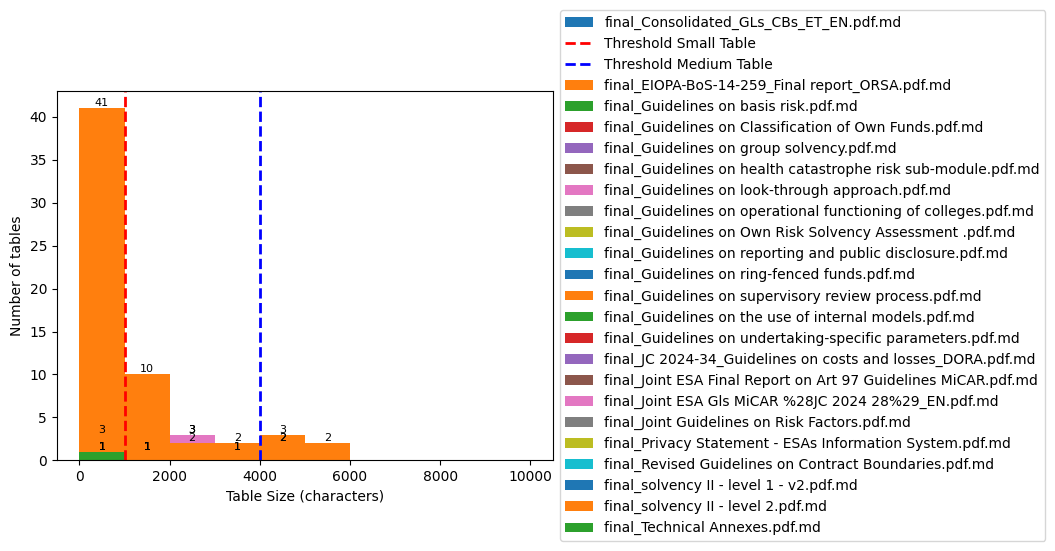

In [15]:
def merge_tables(content):
    mergeable_table_regex = r"(<table>\n*(\|[^\n]+\|\r?\n)((?!</table>).)*?)\n*</table>(\n*--- Page \d+ ---\n*)+<table>\n*(\|[^\n]+\|\r?\n)((?:\|:?[-]+:?)+\|)(.*?\n*</table>)"

    matches = re.finditer(mergeable_table_regex, content, flags=re.DOTALL)

    # print(f"Number of matches (non-strict) {len(list(matches))}")

    strict_matches = []
    for match in matches:
        # print(match.group(1))
        # if "|Zone/<br>Region|AT|BE|CH|CZ|DE|DK|ES|FR|IE|NL|NO|PL|SE|UK|" in match.group(2):
        #     print("Found specific table:")
        #     print(match.group(2) == match.group(5))
        #     print(match.group(2))
        #     print(match.group(5))
        if match.group(2) == match.group(5):
            strict_matches.append(match)

    return strict_matches


input_dir = r"..\data\preprocessed-step-3\solvency-II-files\substep-1"
output_dir = r"..\data\preprocessed-step-3\solvency-II-files\substep-2"
output_dir_TEMP = r"..\data\preprocessed-step-final\solvency-II-files"
output_dir = output_dir_TEMP

with_vline = True

for file_name in os.listdir(input_dir):
    print(file_name)
    if os.path.isfile(os.path.join(input_dir, file_name)):
        with open(os.path.join(input_dir, file_name), "r", encoding="utf-8") as f:
            content = f.read()

        # file_name = "final_solvency II - level 2.pdf.md"
        # with open(output_dir + "\\" + file_name, "r", encoding="utf-8") as f:
        #     content = f.read()

        strict_matches = merge_tables(content)

        # print(f"Found number of matches {len(strict_matches)}")
        # for idx, match in enumerate(matches):
        #     print(f"*** Match {idx}: ***")
        #     print(match.group(0))
        #     print(f"*** End of match {idx} ***")

        while True:
            if not strict_matches:
                print("No more matches, breaking...")
                break
            print(f"Found number of matches {len(strict_matches)}")
            print(f"Original content length: {len(content)}")
            for idx, match in enumerate(strict_matches):
                # print(match.group(0))
                # print(f"*** Replacing for match {idx}: ***")
                content = content.replace(match.group(0), match.group(1) + match.group(7) + "\n" + match.group(4))
            print(f"New content length: {len(content)}")

            strict_matches = merge_tables(content)
            # previous_number_merge_tables = number_merge_tables
            # number_merge_tables = len(strict_matches)

        # root_new_new = "table-examples-out-2"
        with open(output_dir + "\\" + file_name, "w", encoding="utf-8") as f:
            f.write(content)


        table_sizes = []
        for match in re.finditer(table_regex, content, flags=re.MULTILINE):
            table_size = len(match.group(0))
            table_sizes.append(table_size)
            # if table_size > MEDIUM_TABLE_THRESHOLD:
            #     print(f"Large table size: {table_size}")
            #     print(f"content\n {match.group(0)}\n ")

        plot_distribution({file_name: {"table_sizes": table_sizes}}, with_vline=with_vline)
        if with_vline:
            with_vline = False

In [85]:
# the bases is the recursive text splitter.
# to simulate the impact on the real document pipeline, we will split the document into 1000 with 200
from langchain_text_splitters.character import RecursiveCharacterTextSplitter
from langchain_core.documents.base import Document

MAGIC_CHUNK_SIZE = 1000
MAGIC_CHUNK_OVERLAP = 200

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=MAGIC_CHUNK_SIZE,
    chunk_overlap=MAGIC_CHUNK_OVERLAP
)

docs  = text_splitter.transform_documents([Document(page_content=content)])

docs = docs[1261:1356]

# for idx, doc in enumerate(docs):
#     if "<table>" in doc.page_content:
#        print(idx)
        



In [86]:
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_chroma import Chroma
from langchain_openai import AzureOpenAIEmbeddings
import uuid
from langchain.storage import InMemoryByteStore

from dotenv import load_dotenv
load_dotenv()


vectorstore = Chroma(
    collection_name="multi-vector-test-0", embedding_function=AzureOpenAIEmbeddings(model="text-embedding-3-large", api_key=os.environ["AZURE_OPENAI_API_KEY"], azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"], api_version=os.environ["AZURE_TEXT_EMBEDDING_LARGE_VERSION"])
)

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]


sub_docs = []
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=MAGIC_CHUNK_SIZE/2)
for i, doc in enumerate(docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

retriever.vectorstore.add_documents(sub_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [89]:
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_chroma import Chroma
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryByteStore
from langchain.schema import Document
import uuid
import os
from dotenv import load_dotenv

load_dotenv()

# Initialize your components
vectorstore = Chroma(
    collection_name="multi-vector-test-0", 
    embedding_function=AzureOpenAIEmbeddings(
        model="text-embedding-3-large", 
        api_key=os.environ["AZURE_OPENAI_API_KEY"], 
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"], 
        api_version=os.environ["AZURE_TEXT_EMBEDDING_LARGE_VERSION"]
    )
)

store = InMemoryByteStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

# Initialize LLM for generating summaries
llm = AzureChatOpenAI(
    api_key=os.environ["AZURE_OPENAI_API_KEY_SWEDEN"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT_SWEDEN"],
    api_version=os.environ["AZURE_GPT_5_VERSION"],  # Add this to your .env
    deployment_name="gpt-5-chat"  # Add this to your .env
)

def generate_table_summary(table_content: str) -> str:
    """Generate a summary of table content using LLM"""
    prompt = f"""
    Please provide a concise summary of the following table that captures:
    1. What the table is about (main topic/subject)
    2. Key columns and their types of data
    3. Important patterns, trends, or notable information
    4. The table's purpose or what insights it provides
    
    Table content:
    {table_content}
    
    Summary:
    """
    
    response = llm.invoke(prompt)
    return response.content

def add_tables_with_summaries(tables_data):
    """
    Add tables to the retriever with their summaries
    
    Args:
        tables_data: List of dictionaries with 'content' and optional 'metadata'
                    Example: [{'content': 'table_html_or_text', 'metadata': {'source': 'file.pdf'}}]
    """
    
    # Generate unique IDs for each table
    table_ids = [str(uuid.uuid4()) for _ in tables_data]
    
    # Create table documents
    table_docs = []
    table_summaries = []
    
    for i, table_data in enumerate(tables_data):
        table_content = table_data['content']
        table_metadata = table_data.get('metadata', {})
        
        # Create the original table document
        table_doc = Document(
            page_content=table_content,
            metadata={**table_metadata, 'type': 'table'}
        )
        table_docs.append(table_doc)
        
        # Generate summary for the table
        summary = generate_table_summary(table_content)
        
        # Create summary document that will be embedded
        summary_doc = Document(
            page_content=summary,
            metadata={
                **table_metadata,
                id_key: table_ids[i],
                'type': 'table_summary',
                'original_type': 'table'
            }
        )
        table_summaries.append(summary_doc)
    
    # Add summaries to vectorstore (these will be searched)
    retriever.vectorstore.add_documents(table_summaries)
    
    # Store original table documents (these will be retrieved)
    retriever.docstore.mset(list(zip(table_ids, table_docs)))
    
    return table_ids

# Example usage with your existing docs + tables
def process_mixed_documents(docs, tables_data):
    """Process both regular documents and tables"""
    
    # Process regular documents (your existing code)
    doc_ids = [str(uuid.uuid4()) for _ in docs]
    
    sub_docs = []
    child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=MAGIC_CHUNK_SIZE//2)
    
    for i, doc in enumerate(docs):
        _id = doc_ids[i]
        _sub_docs = child_text_splitter.split_documents([doc])
        for _doc in _sub_docs:
            _doc.metadata[id_key] = _id
        sub_docs.extend(_sub_docs)
    
    # Add document chunks to vectorstore
    retriever.vectorstore.add_documents(sub_docs)
    retriever.docstore.mset(list(zip(doc_ids, docs)))
    
    # Process tables with summaries
    table_ids = add_tables_with_summaries(tables_data)
    
    return doc_ids, table_ids

# Example of how to use it
if __name__ == "__main__":
    # Example table data
    tables_data = [
        {
            'content': """
            | Product | Q1 Sales | Q2 Sales | Q3 Sales | Q4 Sales |
            |---------|----------|----------|----------|----------|
            | Widget A| 1000     | 1200     | 1100     | 1300     |
            | Widget B| 800      | 900      | 950      | 1000     |
            | Widget C| 1200     | 1100     | 1250     | 1400     |
            """,
            'metadata': {'source': 'sales_report.pdf', 'page': 5}
        },
        {
            'content': """
            | Employee | Department | Salary | Years |
            |----------|------------|--------|-------|
            | John Doe | Engineering| 75000  | 3     |
            | Jane Smith| Marketing | 65000  | 2     |
            | Bob Wilson| Sales     | 70000  | 5     |
            """,
            'metadata': {'source': 'hr_report.pdf', 'page': 12}
        }
    ]
    
    # Process documents and tables
    doc_ids, table_ids = process_mixed_documents(docs, tables_data)
    
    # Now you can retrieve based on table summaries
    query = "What are the quarterly sales figures for different products?"
    results = retriever.invoke(query, config={"fetch_k": 1})
    
    for result in results:
        print(f"Type: {result.metadata.get('type', 'document')}")
        print(f"Content: {result.page_content[:200]}...")
        print("---")

Type: table
Content: 
            | Product | Q1 Sales | Q2 Sales | Q3 Sales | Q4 Sales |
            |---------|----------|----------|----------|----------|
            | Widget A| 1000     | 1200     | 1100     | 1300  ...
---


In [ ]:
def generate_equation_summary(equation_content: str) -> str:
    """Generate a comprehensive summary of mathematical equation"""
    prompt = f"""
    Please provide a detailed summary of the following mathematical equation that includes:
    1. What the equation represents (physical law, mathematical relationship, etc.)
    2. Key variables and their meanings
    3. The mathematical domain or field it belongs to
    4. What the equation is used to calculate or prove
    5. Any important mathematical properties or constraints
    6. Common applications or contexts where this equation is used
    
    Equation: {equation_content}
    
    Summary:
    """
    
    response = llm.invoke(prompt)
    return response.content

def add_equations_with_summaries(equations_data):
    """Add equations with their summaries for better retrieval"""
    
    equation_ids = [str(uuid.uuid4()) for _ in equations_data]
    equation_docs = []
    equation_summaries = []
    
    for i, eq_data in enumerate(equations_data):
        equation_content = eq_data['content']  # LaTeX, MathML, or text representation
        equation_metadata = eq_data.get('metadata', {})
        
        # Create original equation document
        equation_doc = Document(
            page_content=equation_content,
            metadata={**equation_metadata, 'type': 'equation'}
        )
        equation_docs.append(equation_doc)
        
        # Generate semantic summary
        summary = generate_equation_summary(equation_content)
        
        # Create summary document for embedding
        summary_doc = Document(
            page_content=summary,
            metadata={
                **equation_metadata,
                id_key: equation_ids[i],
                'type': 'equation_summary',
                'original_type': 'equation'
            }
        )
        equation_summaries.append(summary_doc)
    
    # Add summaries to vectorstore (searchable)
    retriever.vectorstore.add_documents(equation_summaries)
    
    # Store original equations (retrievable)
    retriever.docstore.mset(list(zip(equation_ids, equation_docs)))
    
    return equation_ids

In [ ]:
def create_hybrid_math_embedding(equation_data):
    """Combine direct embedding with summary embedding"""
    
    # Direct equation embedding (limited but captures some patterns)
    direct_embedding = embedding_model.embed_query(equation_data['content'])
    
    # Summary-based embedding (captures semantic meaning)
    summary = generate_equation_summary(equation_data['content'])
    summary_embedding = embedding_model.embed_query(summary)
    
    # Weighted combination or separate storage for different retrieval strategies
    return {
        'direct': direct_embedding,
        'semantic': summary_embedding,
        'content': equation_data['content'],
        'summary': summary
    }

In [79]:
len(retriever.vectorstore.similarity_search("justice breyer")[0].page_content)

272

In [80]:
len(retriever.invoke("justice breyer")[0].page_content)

874

# Custom splitter
1. Try to split on different media types